In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM2.5_sensor_and_council.csv')
data.head()

,Datetime,PM2.5_µg/m³_combustion_particles_organic_compounds_metals_sensor,PM2.5_µg/m³_council
0,2024-08-15 15:00:00,4.483333,4.8
1,2024-08-15 16:00:00,4.766667,3.8
2,2024-08-15 17:00:00,3.533333,7.1
3,2024-08-15 18:00:00,4.733333,6.4
4,2024-08-16 11:00:00,6.300000,3.8


In [3]:
X = data[['PM2.5_µg/m³_combustion_particles_organic_compounds_metals_sensor']].values
y = data['PM2.5_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[ 5.17647059],
       [15.83673469],
       [ 7.88235294],
       [18.33898305],
       [ 8.7       ]])

array([[-0.37955884],
       [ 2.37163311],
       [ 0.31877299],
       [ 3.01741125],
       [ 0.52979065]])

array([[0.75      ],
       [7.55      ],
       [3.8125    ],
       [1.01666667],
       [6.3       ]])

array([[-1.52193863],
       [ 0.23299962],
       [-0.73157122],
       [-1.45311752],
       [-0.08959932]])

## Experimented List of Models and Parameters

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

params = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3]
    },
    'Ridge': {
        'ridge__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'Lasso': {
        'lasso__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'ElasticNet': {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 150, 200],
        'randomforest__max_depth': [5, 7, 10]
    },
    'Gradient Boosting': {
        'gradientboosting__n_estimators': [50, 100, 150, 200],
        'gradientboosting__learning_rate': [0.001, 0.01, 0.1],
        'gradientboosting__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 150, 200],
        'xgboost__learning_rate': [0.001, 0.01, 0.1],
        'xgboost__max_depth': [3, 5, 7],
        'xgboost__subsample': [0.6, 0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'k-nearestneighbors__n_neighbors': [3, 5, 7, 9],
        'k-nearestneighbors__weights': ['uniform', 'distance'],
        'k-nearestneighbors__p': [1, 2]
    },
    'AdaBoost': {
        'adaboost__n_estimators': [50, 100, 150, 200],
        'adaboost__learning_rate': [0.001, 0.01, 0.1],
        'adaboost__loss': ['linear', 'square', 'exponential']
    }
}

polynomial_models = ['Linear Regression', 'Ridge', 'Lasso']

#### 1. polynomial_models is the list of models for which a polynomial feature transformation is required
#### 2. We create a pipeline for those models to transform the features before feeding them to the model.
#### 3. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 4. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [8]:
best_models = []
best_score = float('-inf')
best_model_name = ''
best_params = {}

for model_name in models:
    print(f"Training {model_name}...")
    steps = []

    if model_name in polynomial_models:
        steps.append(('poly', PolynomialFeatures(include_bias=False)))
        
    model_param_key = model_name.lower().replace(' ', '')
    steps.append((model_param_key, models[model_name]))
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=True)
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        model_score = grid_search.best_score_
        
        best_models.append({
            'name': model_name,
            'model': grid_search.best_estimator_,
            'params': grid_search.best_params_,
            'rmse': model_score
        })

    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training Linear Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Results

In [9]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

#### For showcasing model with the best R2

In [10]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: AdaBoost
Best Hyperparameters: {'poly__degree': 3}
Test RMSE: 1.8461
Test MSE: 3.4081
Test R2: 0.8489
Test MAE: 1.5761


,Actual,Predicted
0,5.3,2.774601
1,5.0,6.227174
2,4.3,4.474153
3,6.3,2.940990
4,3.8,5.648353
5,6.3,6.943320
6,4.0,3.482422
7,2.0,2.930715
8,5.9,5.021751
9,7.4,5.340866


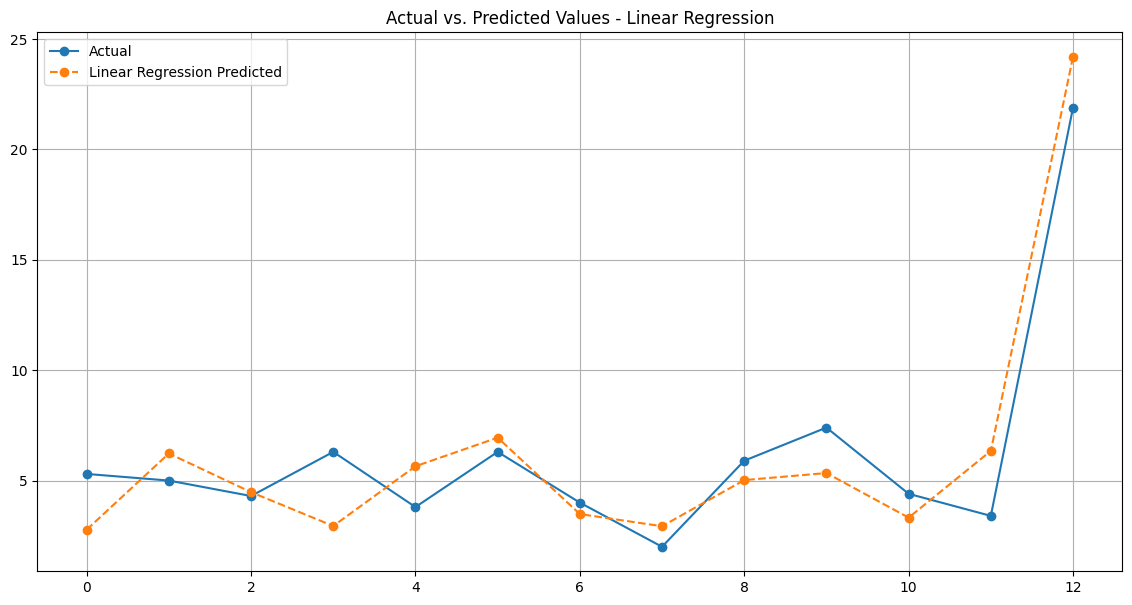


Results For Model: Linear Regression
Best Hyperparameters: {'poly__degree': 3, 'ridge__alpha': 0.01}
Test RMSE: 1.8494
Test MSE: 3.4201
Test R2: 0.8484
Test MAE: 1.5785


,Actual,Predicted
0,5.3,2.773814
1,5.0,6.226865
2,4.3,4.475830
3,6.3,2.940632
4,3.8,5.649076
5,6.3,6.941605
6,4.0,3.483198
7,2.0,2.930332
8,5.9,5.023230
9,7.4,5.342022


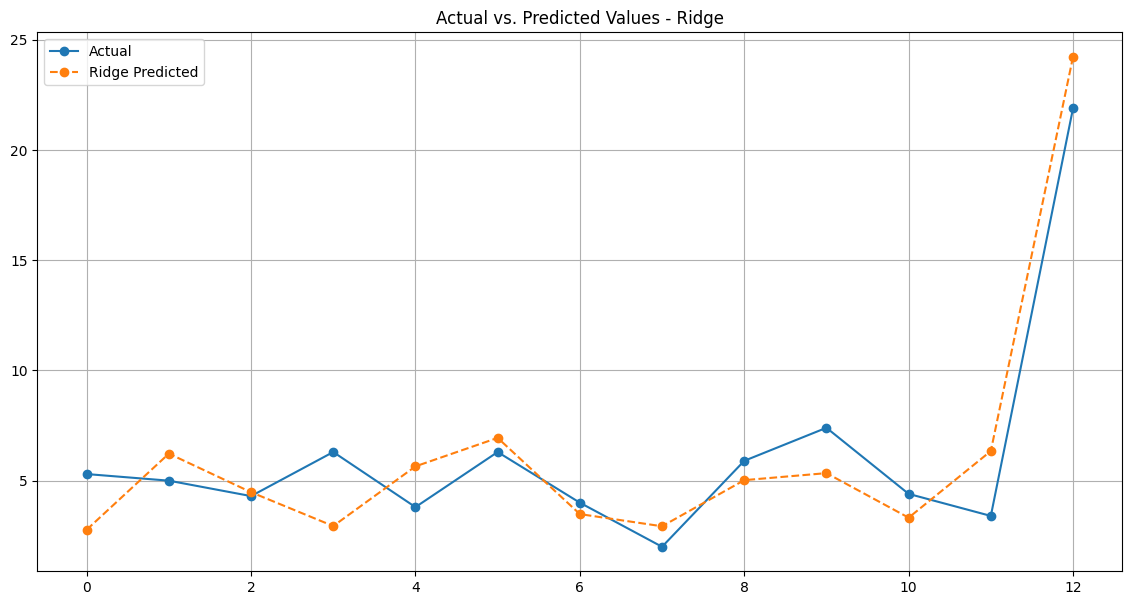


Results For Model: Ridge
Best Hyperparameters: {'lasso__alpha': 0.1, 'poly__degree': 3}
Test RMSE: 2.0768
Test MSE: 4.3131
Test R2: 0.8088
Test MAE: 1.6761


,Actual,Predicted
0,5.3,2.957611
1,5.0,6.143698
2,4.3,4.625965
3,6.3,3.130777
4,3.8,5.654556
5,6.3,6.755219
6,4.0,3.680142
7,2.0,3.120141
8,5.9,5.115494
9,7.4,5.392154


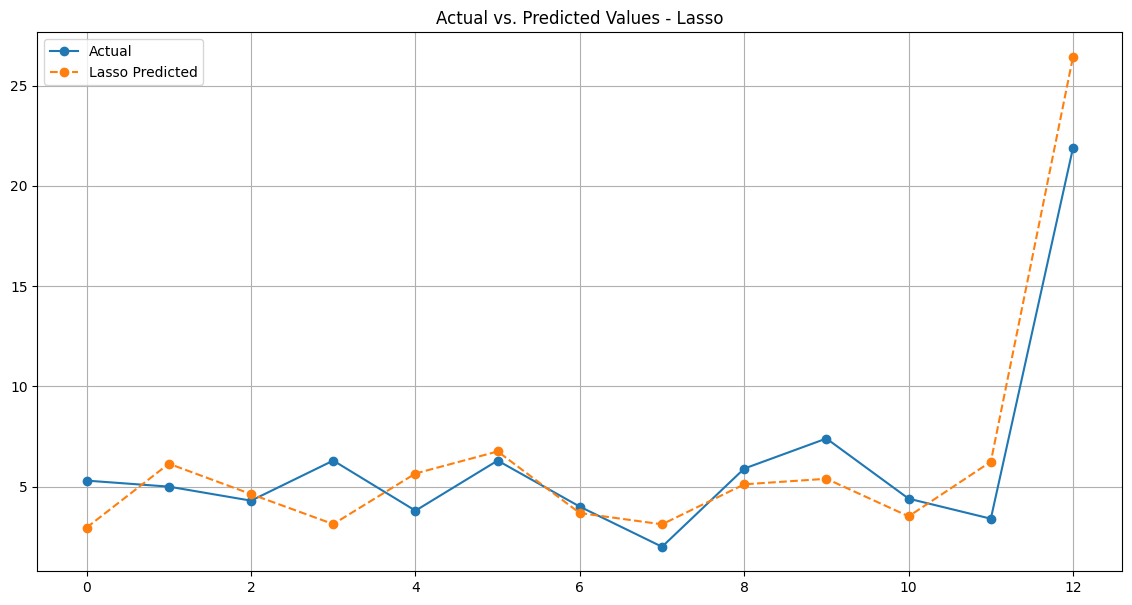


Results For Model: Lasso
Best Hyperparameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}
Test RMSE: 2.4618
Test MSE: 6.0604
Test R2: 0.7313
Test MAE: 1.9842


,Actual,Predicted
0,5.3,2.436208
1,5.0,6.481976
2,4.3,4.258291
3,6.3,2.594865
4,3.8,5.738269
5,6.3,7.364509
6,4.0,3.140251
7,2.0,2.584949
8,5.9,4.934561
9,7.4,5.341625


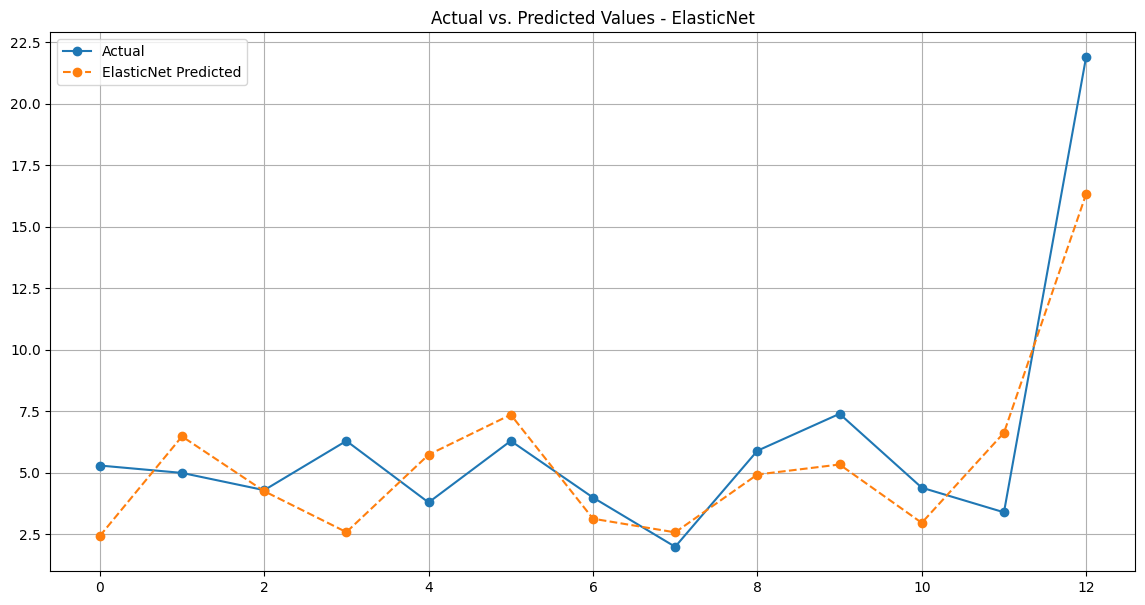


Results For Model: ElasticNet
Best Hyperparameters: {'adaboost__learning_rate': 0.001, 'adaboost__loss': 'linear', 'adaboost__n_estimators': 200}
Test RMSE: 2.4722
Test MSE: 6.1117
Test R2: 0.7290
Test MAE: 1.7884


,Actual,Predicted
0,5.3,4.000000
1,5.0,6.640000
2,4.3,5.306250
3,6.3,4.000000
4,3.8,4.990000
5,6.3,6.800000
6,4.0,3.975000
7,2.0,4.000000
8,5.9,4.988889
9,7.4,4.692308


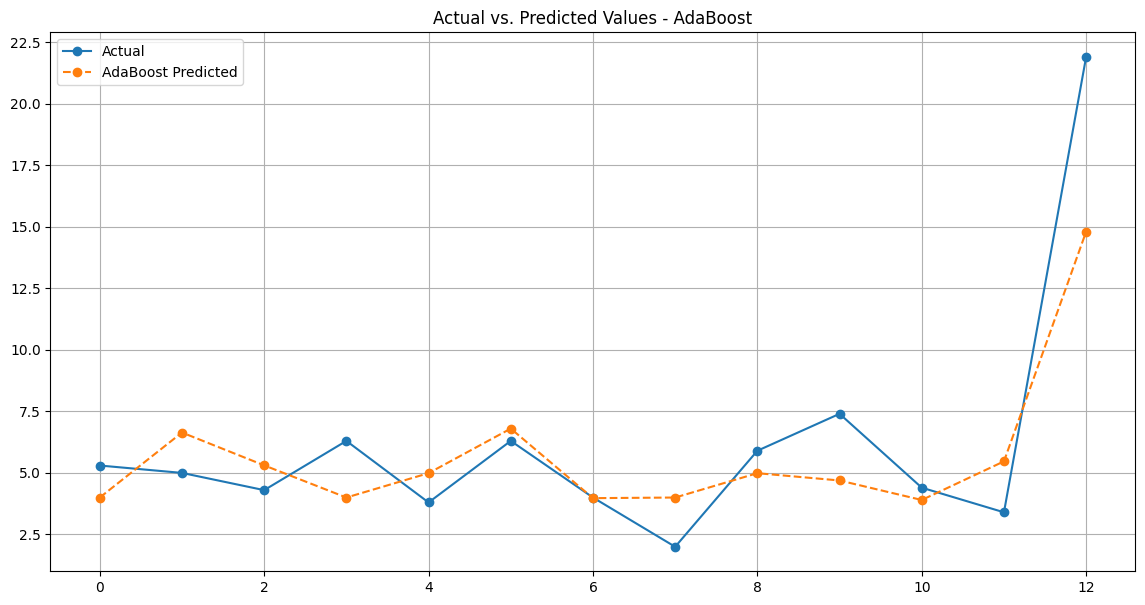


Results For Model: AdaBoost
Best Hyperparameters: {'randomforest__max_depth': 5, 'randomforest__n_estimators': 150}
Test RMSE: 3.2709
Test MSE: 10.6985
Test R2: 0.5256
Test MAE: 2.3320


,Actual,Predicted
0,5.3,3.519898
1,5.0,7.705537
2,4.3,5.879013
3,6.3,3.519898
4,3.8,5.329932
5,6.3,6.895886
6,4.0,4.305096
7,2.0,3.519898
8,5.9,4.828687
9,7.4,3.251548


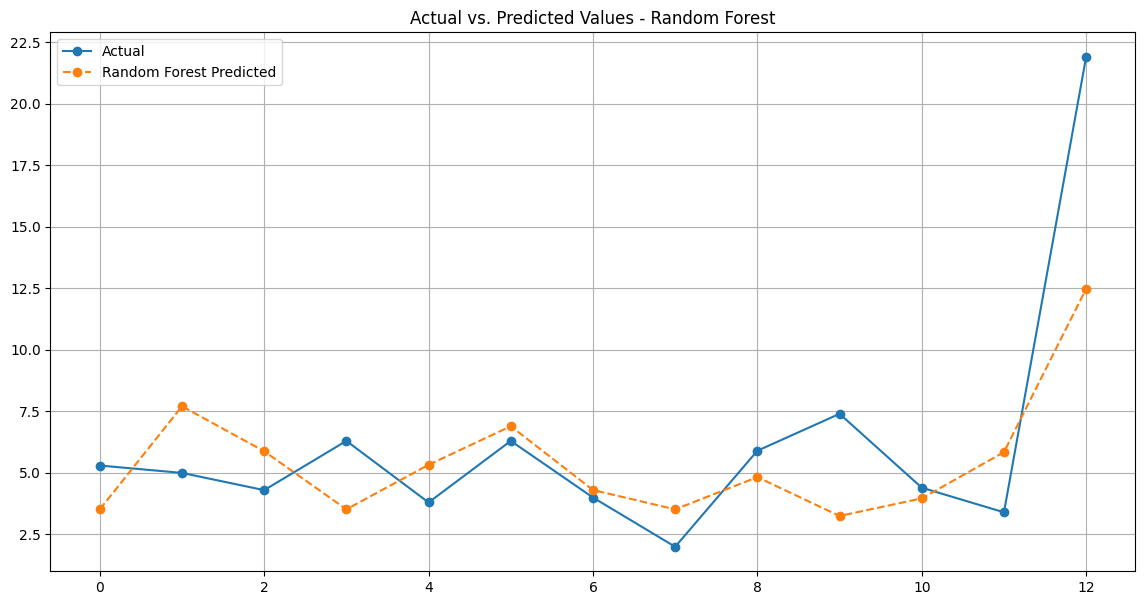


Results For Model: Random Forest
Best Hyperparameters: {'gradientboosting__learning_rate': 0.01, 'gradientboosting__max_depth': 3, 'gradientboosting__n_estimators': 50}
Test RMSE: 3.8610
Test MSE: 14.9076
Test R2: 0.3390
Test MAE: 2.3389


,Actual,Predicted
0,5.3,4.967204
1,5.0,7.941590
2,4.3,5.718898
3,6.3,4.967204
4,3.8,5.433180
5,6.3,6.318156
6,4.0,5.175831
7,2.0,4.967204
8,5.9,5.433180
9,7.4,5.433180


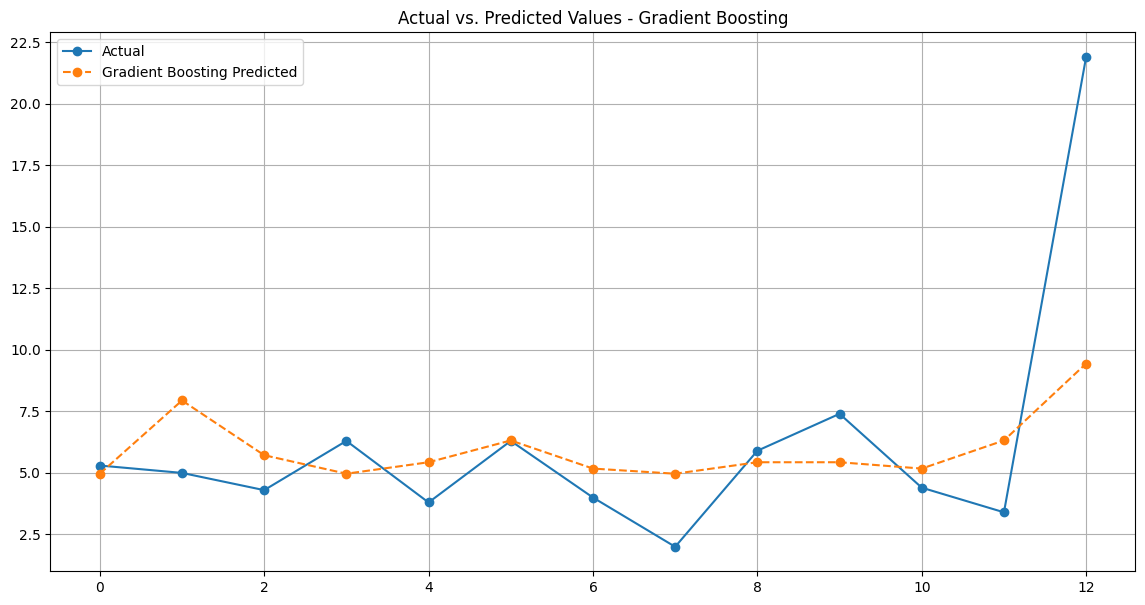


Results For Model: Gradient Boosting
Best Hyperparameters: {'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 100, 'xgboost__subsample': 0.6}
Test RMSE: 3.9759
Test MSE: 15.8076
Test R2: 0.2991
Test MAE: 2.2334


,Actual,Predicted
0,5.3,4.638748
1,5.0,5.811043
2,4.3,5.694464
3,6.3,4.638748
4,3.8,5.049269
5,6.3,6.682416
6,4.0,4.666655
7,2.0,4.638748
8,5.9,5.381471
9,7.4,5.049269


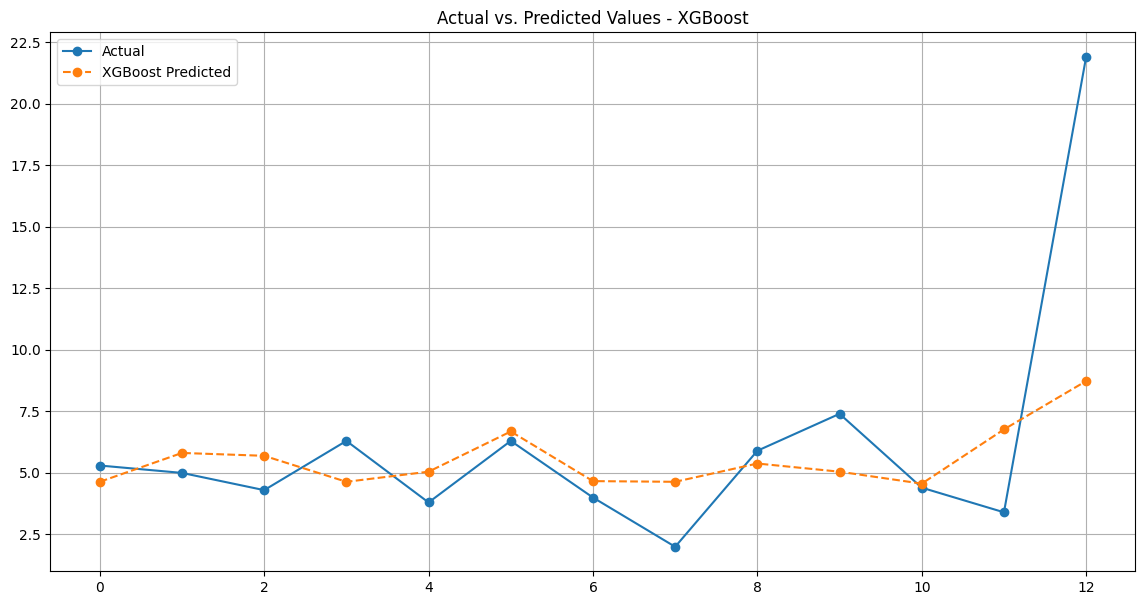


Results For Model: XGBoost
Best Hyperparameters: {'k-nearestneighbors__n_neighbors': 9, 'k-nearestneighbors__p': 1, 'k-nearestneighbors__weights': 'uniform'}
Test RMSE: 4.1115
Test MSE: 16.9041
Test R2: 0.2505
Test MAE: 2.3726


,Actual,Predicted
0,5.3,4.155556
1,5.0,6.755556
2,4.3,4.455556
3,6.3,4.155556
4,3.8,5.155556
5,6.3,7.222222
6,4.0,4.155556
7,2.0,4.155556
8,5.9,4.588889
9,7.4,4.877778


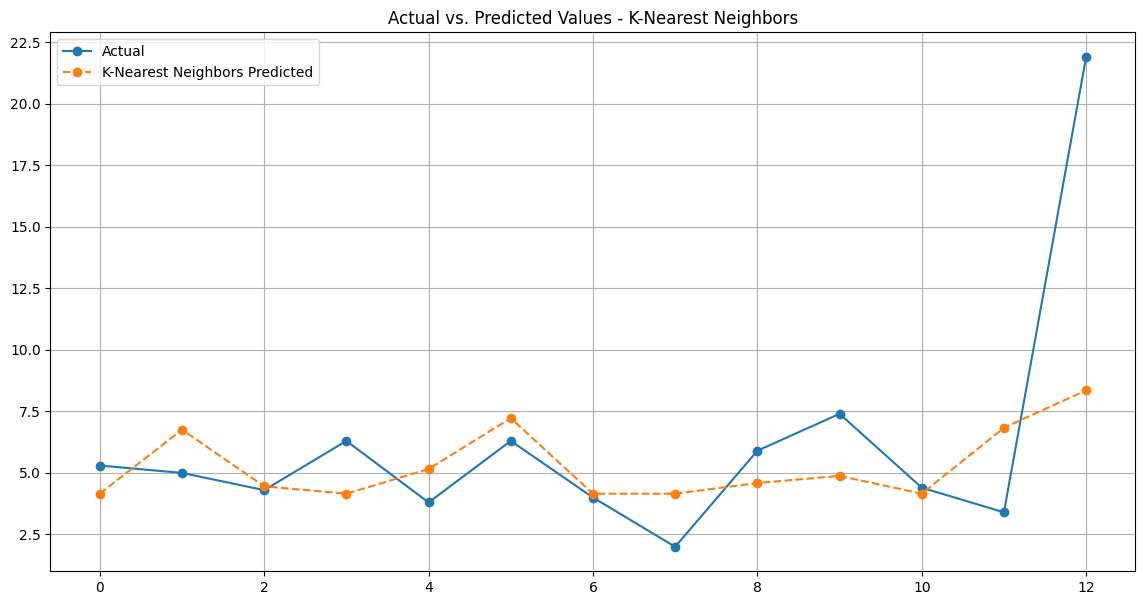

In [11]:
for result in results:
    print(f"Results For Model: {model_name}")
    model_name = result['name']
    print(f"Best Hyperparameters: {result['params']}")
    test_rmse = result['rmse']
    test_mse = result['mse']
    test_r2 = result['r2']
    test_mae = result['mae']
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [12]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,Linear Regression,1.846099,3.408082,0.848887,1.576069
1,Ridge,1.849356,3.420116,0.848354,1.578517
2,Lasso,2.076796,4.313082,0.808760,1.676086
3,ElasticNet,2.461787,6.060396,0.731285,1.984175
4,AdaBoost,2.472188,6.111715,0.729010,1.788406
5,Random Forest,3.270860,10.698524,0.525633,2.331957
6,Gradient Boosting,3.861041,14.907638,0.339003,2.338886
7,XGBoost,3.975877,15.807599,0.299099,2.233402
8,K-Nearest Neighbors,4.111460,16.904103,0.250481,2.372650
